In [1]:
from mps_utils import * 
from wave_circuit import * 
from density import * 
import matplotlib.pyplot as plt
from qiskit.quantum_info import Statevector, Operator

In [2]:
n = 10 
N = 2**n

In [3]:
sigma = 0.1 
mu = 0.5


f = lambda x: 2/(np.sqrt(3 * sigma) * (np.pi)**(1/4)) * (1 - ((x-mu)/sigma)**2 ) * np.exp(- (x-mu)**2/(2*sigma**2))
df = lambda x: -4/(np.sqrt(3 * sigma) * (np.pi)**(1/4)) * (x-mu)/(sigma**2) * np.exp(- (x-mu)**2/(2*sigma**2)) - (x-mu)/(sigma**2) * f(x)

init_state = np.concatenate([f(np.linspace(0, 1-1/N, N)), np.zeros(N)])
K = np.linalg.norm(init_state)
init_state = init_state/K

f_extend = lambda x : f(x - np.floor(x))/K
df_extend = lambda x : df(x - np.floor(x))/K

In [4]:

f_evo = lambda x,t :  1/2 * (f_extend(x - t) + f_extend(x + t))

dxf_evo = lambda x,t :1/2 * (df_extend(x - t) + df_extend(x + t))
dtf_evo = lambda x,t : 1/2 * (-df_extend(x - t) + df_extend(x + t))

In [5]:
def n_int(fun):
    return 1/N * np.sum([fun(_) for _ in np.linspace(0, 1 - 1/N, N)])

def T(t):
    return n_int(lambda x : dtf_evo(x,t)**2)

def U(t):
    return n_int(lambda x : dxf_evo(x,t)**2)


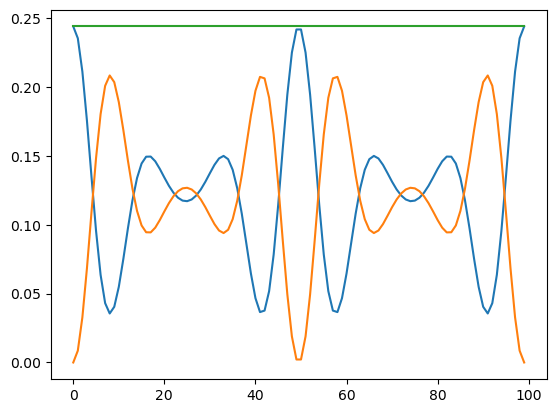

In [6]:
plt.plot([U(_) for _ in np.linspace(0,1, 100)])
plt.plot([T(_) for _ in np.linspace(0,1, 100)])
plt.plot([T(_) + U(_) for _ in np.linspace(0,1, 100)])

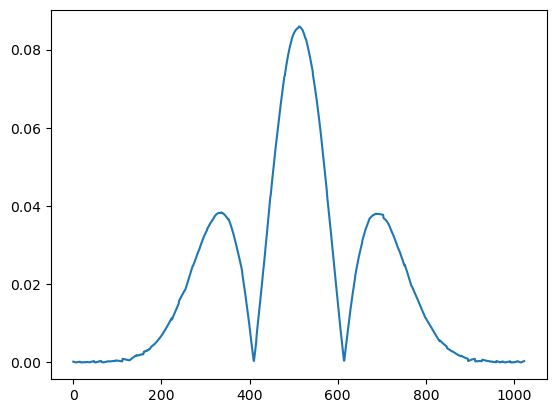

In [7]:
layers = np.load('mps.npy', allow_pickle=True)
state_prep_circ = convert_layers_to_circuit(layers)
plt.plot(abs(Statevector(state_prep_circ.reverse_bits()).data))

In [8]:
exact_state = f(np.linspace(0, 1-1/N, N))
exact_state = exact_state/K 
1-abs(np.dot(exact_state, Statevector(state_prep_circ.reverse_bits()).data))**2

np.float64(2.5741244237709182e-05)

In [184]:
t = 0.0
full_circuit = QuantumCircuit(n+1)
full_circuit = full_circuit.compose(state_prep_circ, range(1,n+1))
full_circuit = full_circuit.compose(energy_circuit(n, swap=False).assign_parameters([t]), range(n+1))
state = Statevector(full_circuit.reverse_bits()).data
energy_expectation(state, swap = True)

(np.complex128(0.2543313354437617-3.105236019524066e-21j),
 np.complex128(4.3311237836297594e-35+4.116629114067968e-54j))

In [185]:
rho = get_density_matrix(full_circuit, 5e-4)

In [186]:
spec = np.clip(spectrum_P(N), -4, 0)
U_op = np.kron(np.eye(2), swap_matrix(n)) @ np.block([[np.diag(spec), np.zeros((N,N))], [np.zeros((N,N)), np.zeros((N,N))]]) @ np.kron(np.eye(2), swap_matrix(n))
T_op = np.kron(np.eye(2), swap_matrix(n)) @ np.block([[np.zeros((N,N)), np.zeros((N,N))], [np.zeros((N,N)), np.diag(spec)]]) @ np.kron(np.eye(2), swap_matrix(n))


In [187]:
U_targ = state.conjugate().T @ U_op @ state * -N
T_targ = state.conjugate().T @ T_op @ state * -N
U_targ, T_targ

(np.complex128(0.25433133544376174-4.0657581468206416e-20j),
 np.complex128(4.331123783629763e-35+2.088097429759528e-53j))

In [240]:
# U_list = []
# T_list = []
# circs  = []
# for p in np.linspace(0, 1, 10):
#     temp_U_list = []
#     temp_T_list = []
#     for _ in range(10):
#         folded_circ = fold_circ(full_circuit, p)
#         circs.append(folded_circ)
#         rho = get_density_matrix(folded_circ,5e-4)
        
#         temp_U_list.append(np.trace(rho @ U_op))
#         temp_T_list.append(np.trace(rho @ T_op))
#     U_list.append(temp_U_list)
#     T_list.append(temp_T_list)

import numpy as np
from joblib import Parallel, delayed
import sys 

def process_one(p):
    """Run one batch for given p."""
    temp_U_list = []
    temp_T_list = []
    temp_circs  = []
    for _ in range(10):
        folded_circ = fold_circ(full_circuit, p)
        rho = get_density_matrix(folded_circ, 1e-5)
        temp_circs.append(folded_circ)

        temp_U_list.append(np.trace(rho @ U_op))
        temp_T_list.append(np.trace(rho @ T_op))
    sys.stdout.write(f"Finished p={p:.2f}\n")
    sys.stdout.flush()
    return temp_U_list, temp_T_list, temp_circs

# Run in parallel
results = Parallel(n_jobs=-1, prefer="processes")(
    delayed(process_one)(p) for p in np.linspace(0, 1, 10)
)

# Unpack results
U_list, T_list, circs = zip(*results)

In [241]:
# U_list = [] 
# T_list = [] 
# circs = []

# for p in np.linspace(0, 1, 10): 
#     temp_U_list = [] 
#     temp_T_list = [] 
#     temp_circs = []
#     for _ in range(2): 
#         folded_circ = fold_circ(full_circuit, p) 
#         temp_circs.append(folded_circ) 
#         rho = get_density_matrix(folded_circ,5e-4) 
#         temp_U_list.append(np.trace(rho @ U_op)) 
#         temp_T_list.append(np.trace(rho @ T_op))
#     U_list.append(temp_U_list)
#     T_list.append(temp_T_list)
#     circs.append(temp_circs)

(0.0, 3.0)

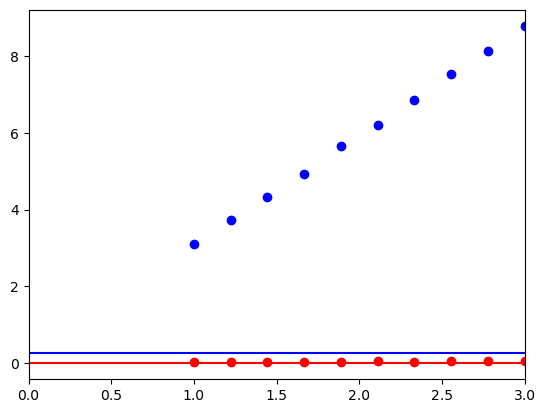

In [242]:
plt.scatter(1+2*np.linspace(0, 1, 10), np.mean(U_list, axis=1).real * (-N), color = 'b')
plt.scatter(1+2*np.linspace(0, 1, 10), np.mean(T_list, axis=1).real * (-N), color = 'r')

plt.axhline(U_targ.real, color = 'b')
plt.axhline(T_targ.real, color = 'r')

plt.xlim(0, 3)

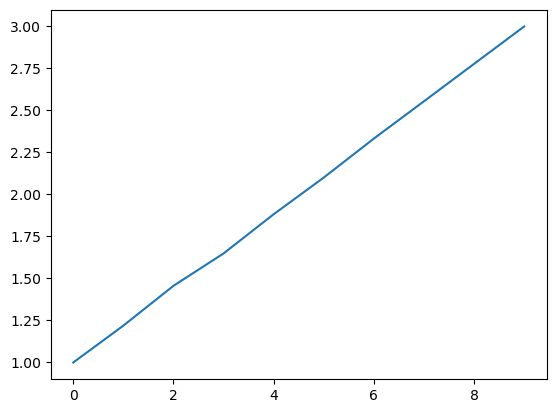

In [243]:
plt.plot([np.mean([len(_) for _ in c])/len(full_circuit) for c in circs])

U fit R²: 0.9998
T fit R²: 0.9360


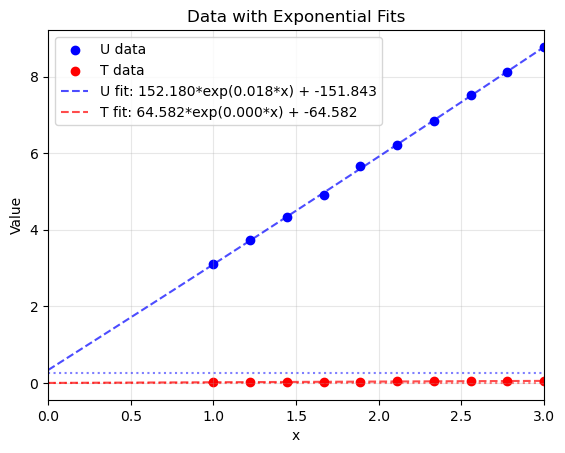

In [244]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define exponential function
def exponential_func(x, a, b, c):
    return a * np.exp(b * x) + c

# Your original data
x_data = 1 + 2 * np.linspace(0, 1, 10)
U_data = np.mean(U_list, axis=1).real * (-N)
T_data = np.mean(T_list, axis=1).real * (-N)

# Original scatter plots
plt.scatter(x_data, U_data, color='b', label='U data')
plt.scatter(x_data, T_data, color='r', label='T data')

# Fit exponential curves
try:
    # Fit for U data
    popt_U, pcov_U = curve_fit(exponential_func, x_data, U_data, maxfev=5000)
    
    # Fit for T data
    popt_T, pcov_T = curve_fit(exponential_func, x_data, T_data, maxfev=5000)
    
    # Generate smooth curve for plotting
    x_smooth = np.linspace(0, 3, 100)
    U_fit = exponential_func(x_smooth, *popt_U)
    T_fit = exponential_func(x_smooth, *popt_T)
    
    # Plot fits
    plt.plot(x_smooth, U_fit, 'b--', alpha=0.7, 
             label=f'U fit: {popt_U[0]:.3f}*exp({popt_U[1]:.3f}*x) + {popt_U[2]:.3f}')
    plt.plot(x_smooth, T_fit, 'r--', alpha=0.7, 
             label=f'T fit: {popt_T[0]:.3f}*exp({popt_T[1]:.3f}*x) + {popt_T[2]:.3f}')
    
    # Print R-squared values
    U_residuals = U_data - exponential_func(x_data, *popt_U)
    U_ss_res = np.sum(U_residuals ** 2)
    U_ss_tot = np.sum((U_data - np.mean(U_data)) ** 2)
    U_r_squared = 1 - (U_ss_res / U_ss_tot)
    
    T_residuals = T_data - exponential_func(x_data, *popt_T)
    T_ss_res = np.sum(T_residuals ** 2)
    T_ss_tot = np.sum((T_data - np.mean(T_data)) ** 2)
    T_r_squared = 1 - (T_ss_res / T_ss_tot)
    
    print(f"U fit R²: {U_r_squared:.4f}")
    print(f"T fit R²: {T_r_squared:.4f}")
    
except RuntimeError:
    print("Could not fit exponential curve. Data might not follow exponential trend.")

# Original horizontal lines
plt.axhline(U_targ.real, color='b', alpha=0.5, linestyle=':')
plt.axhline(T_targ.real, color='r', alpha=0.5, linestyle=':')

plt.xlim(0, 3)
plt.legend()
plt.xlabel('x')
plt.ylabel('Value')
plt.title('Data with Exponential Fits')
plt.grid(True, alpha=0.3)
plt.show()

In [245]:
exponential_func(0, *popt_U)

np.float64(0.33768926106526465)

In [246]:
exponential_func(0, *popt_T)

np.float64(0.0006510966327084589)

In [247]:
U_targ

np.complex128(0.25433133544376174-4.0657581468206416e-20j)

In [248]:
T_targ

np.complex128(4.331123783629763e-35+2.088097429759528e-53j)